# Loading and visualizing results ([open in colab](https://colab.research.google.com/github/openai/baselines/blob/master/docs/viz/viz.ipynb))
In order to compare performance of algorithms, we often would like to visualize learning curves (reward as a function of time steps), or some other auxiliary information about learning aggregated into a plot. Baselines repo provides tools for doing so in several different ways, depending on the goal.

## Preliminaries / TensorBoard
First, let us install baselines repo from github

In [1]:
1

1

For all algorithms in baselines summary data is saved into a folder defined by logger. By default, a folder $TMPDIR/openai-<date>-<time> is used; you can see the location of logger directory at the beginning of the training in the message like this:

Logging to /var/folders/mq/tgrn7bs17s1fnhlwt314b2fm0000gn/T/openai-2018-10-29-15-03-13-537078
The location can be changed by changing OPENAI_LOGDIR environment variable. For instance, 

In [6]:
!OPENAI_LOGDIR=$HOME/logs/cartpole-ppo OPENAI_LOG_FORMAT=csv python -m baselines.run --alg=ppo2 --env=CartPole-v0 --num_timesteps=30000 --nsteps=128

env_type: classic_control
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 128, 'network': 'mlp'}


Notice also the usage of `OPENAI_LOG_FORMAT` environment variable - this allows us to suppress printing to stdout. 
Permissible values for `OPENAI_LOG_FORMAT` environment variables are `stdout`, `log`, `csv`, and `tensorboard` (multiple values can be comma-separated). 
The latter one (`tensorboard`) dumps values in tensorboard format, which allows for their viewing in [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard). TensorBoard provides nice visualization and in many cases is the easiest way to look at the summary of the results. However, if tensorboard visualization is not sufficient, read on...


## Loading results and plotting using matplotlib
Bаselines provides helper functions to load the summaries of the results as pandas dataframes. 
For instance, the following:

In [11]:
from baselines.common import plot_util as pu
results = pu.load_results('~/logs/cartpole-ppo') 

In [38]:
import matplotlib.pyplot as plt
import numpy as np
r = results[6]
np.array(r.progress['AverageReturn'])
type(r.progress['misc/nupdates']//10)
r.progress.AverageReturn
import pandas as pd
type(pd.DataFrame(r.progress.index)[0])

pandas.core.series.Series

will search for all folders with baselines-compatible results in ~/logs/cartpole-ppo and subfolders and return a list of `Result` objects. Each `Result` object is a named tuple with the following fields:

  * dirname: str - name of the folder from which data was loaded
  
  * metadata: dict) - dictionary with various metadata (read from metadata.json file)

  * progress: pandas.DataFrame - tabular data saved by logger as a pandas dataframe. Available if csv is in logger formats.

  * monitor: pandas.DataFrame - raw episode data (length, episode reward, timestamp). Available if environment wrapped with Monitor wrapper
  
Thus, a learning curve from a single run can be plotted as follows (note the cumulative sum trick to get convert lengths of the episodes into number of time steps taken so far)
 

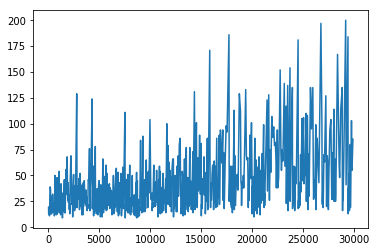

In [12]:
import matplotlib.pyplot as plt
import numpy as np
r = results[0]
plt.plot(np.cumsum(r.monitor.l), r.monitor.r)

The raw learning curve from a single run can be very noisy. To smoothen it and analyze if any learning actually takes place, we can use `plot_util.smooth()` function:

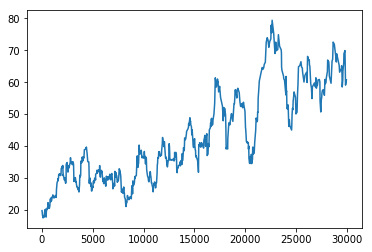

In [13]:
plt.plot(np.cumsum(r.monitor.l), pu.smooth(r.monitor.r, radius=10))

In [13]:
r.progress['AverageReturn']
1

1

Similar curve can be obtained by using logger summaries (instead of raw episode data in monitor.csv):


RangeIndex(start=0, stop=24, step=1)

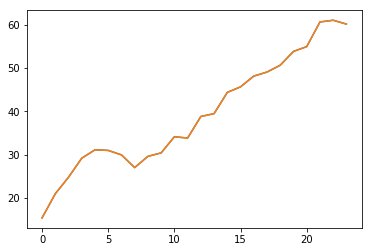

In [17]:
#plt.plot(r.progress['misc/total_timesteps'], r.progress.eprewmean)
plt.plot(r.progress['misc/total_timesteps']//1280, r.progress.eprewmean)
r.progress.index
plt.plot(r.progress.index, r.progress.eprewmean)
r.progress['misc/total_timesteps']
r.progress.index

Note, however, that raw episode data is stored by the Monitor wrapper, and hence looks similar for all algorithms, whereas progress data is handled by the algorithm itself, and hence can vary (column names, type of data available) between algorithms.

## Plotting: many curves
While the loading and plotting functions described above in principle give you access to any slice of the training summaries, sometimes it is necessary to plot and compare many training runs (multiple algorithms, multiple seeds for random number generator), and usage of the functions above can get tedious and messy. For that case, `baselines.common.plot_util` provides convenience function plot_results that handles multiple `Result` objects that need to be routed in multiple plots. Consider the following bash snippet that runs ppo2 with cartpole with 6 different seeds for 30k time steps, first with rollout batch size 32, and then with batch size 128 (note that the next cell will take a little while to run):

In [38]:
!for seed in $(seq 0 5); do OPENAI_LOG_FORMAT=csv OPENAI_LOGDIR=$HOME/logs/cartpole-ppo-hp/b32-$seed python -m baselines.run --alg=ppo2 --env=CartPole-v0 --num_timesteps=1e4 --seed=$seed --nsteps=32; done
!for seed in $(seq 0 5); do OPENAI_LOG_FORMAT=csv OPENAI_LOGDIR=$HOME/logs/cartpole-ppo-hp/b128-$seed python -m baselines.run --alg=ppo2 --env=CartPole-v0 --num_timesteps=1e4 --seed=$seed --nsteps=128; done

env_type: classic_control
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 32, 'network': 'mlp'}
env_type: classic_control
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 32, 'network': 'mlp'}
env_type: classic_control
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 32, 'network': 'mlp'}
env_type: classic_control
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Training ppo2 on classic_control:CartPole-v0 with arguments 
{'nsteps': 32, 'network': 'mlp'}
env_type: classic_control
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

The results of 12 runs from the cell above can be loaded just as before, via (we discard first result that is actually from the very first run in the previous section):

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from baselines.common import plot_util as pu
results = pu.load_results('~/logs/cartpole-ppo-hp'); print(len(results))

12


/Users/zsbjltwjj/Desktop/carla_sample_efficient/baselines/bench/monitor.py:161: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


But how do we plot all 12 of them in a sensible manner? `baselines.common.plot_util` module provides plot_results function to do just that:

(<Figure size 432x864 with 2 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11caaeb38>],
       dtype=object))

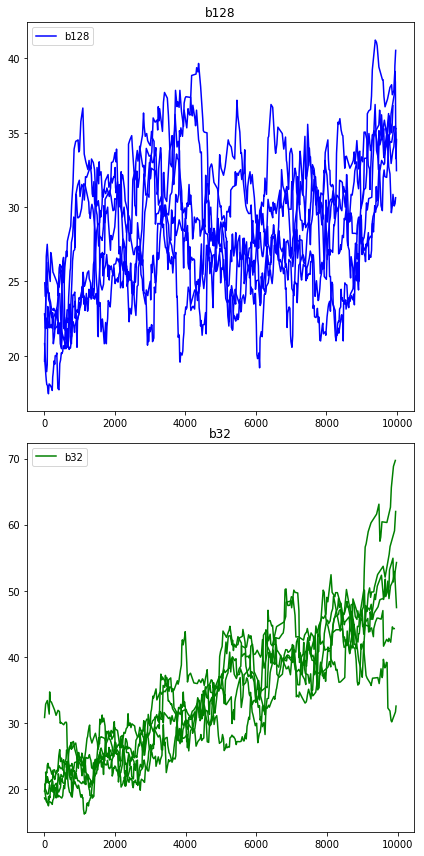

In [16]:
pu.plot_results(results)

The results are split into two groups based on batch size and are plotted on a separate graph. More specifically, by default plot_results considers digits after dash at the end of the directory name to be seed id and groups the runs that differ only by those together.

Showing all seeds on the same plot may be somewhat hard to comprehend and analyse. We can instead average over all seeds via the following command:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from baselines.common import plot_util as pu
results = pu.load_results('~/logs/cartpole-ppo-hp')
#results2 = pu.load_results('~/Desktop/logs/trpo_Pd_0')
#pu.plot_results(results,xy_fn=pu.progress_ppo_default_xy_fn,average_group=True)
results = pu.load_results('~/Desktop/logs/EXP1/'+'HalfCheetah-v2')
pu.plot_results(results,xy_fn=pu.progress_iter_xy_fn,average_group=True)


/Users/zsbjltwjj/Desktop/carla_sample_efficient/baselines/bench/monitor.py:161: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


(<Figure size 600x1800 with 3 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11792ed68>],
       dtype=object))

The lighter shade shows the standard deviation of data, and darker shade - error in estimate of the mean (that is, standard deviation divided by square root of number of seeds). Note that averaging over seeds requires resampling to a common grid, which, in turn, requires smoothing (using language of signal processing, we need to do low-pass filtering before resampling to avoid aliasing effects). You can change the amount of smoothing by adjusting `resample` and `smooth_step` arguments to achieve desired smoothing effect See the docstring of plot_util function for more info.

To plot both groups on the same graph, we can use the following:

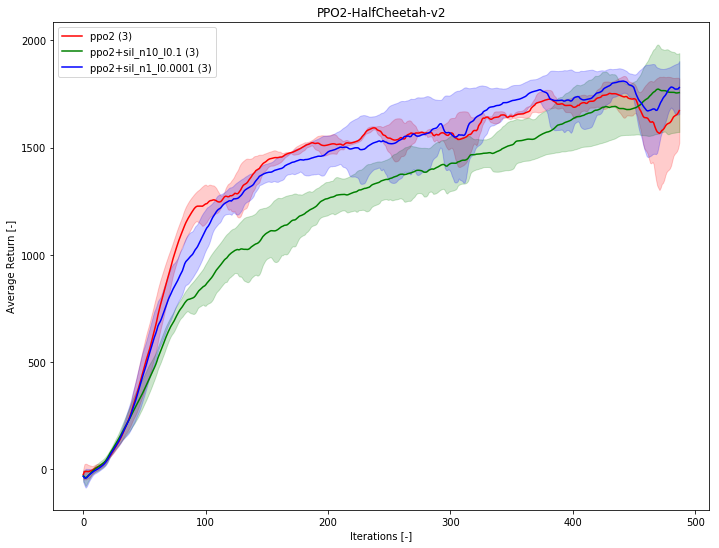

In [3]:
pu.plot_results(results, xy_fn=pu.progress_iter_xy_fn, average_group=True, split_fn=lambda _: '',shaded_err=False)
plt.title("PPO2-HalfCheetah-v2")
plt.xlabel('Iterations [-]')
plt.ylabel('Average Return [-]')
fig = plt.gcf()
fig.set_size_inches(10.5, 7.5)
fig.savefig("/Users/zsbjltwjj/Desktop/test_env.png")

Option `split_fn=labmda _:''` effectively disables splitting, so that all curves end up on the same panel.

Now, with many groups the overlapping shaded regions may start looking messy. We can disable either light shaded region (corresponding to standard deviation of the curves in the group) or darker shaded region (corresponding to the error in mean estimate) by using `shaded_std=False` or `shaded_err=False` options respectively. For instance,

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<cla

(<Figure size 432x432 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124a3b4e0>]],
       dtype=object))

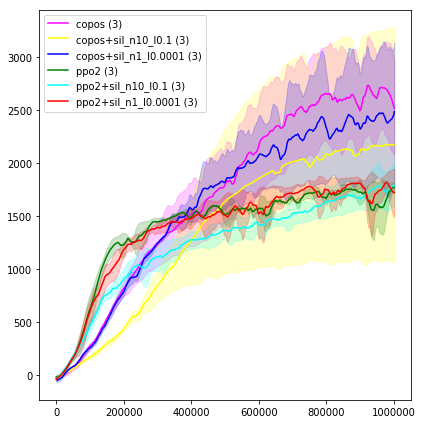

In [7]:
pu.plot_results(results, average_group=True, split_fn=lambda _: '', shaded_err=False)

In [18]:
results[].dirname

'/Users/zsbjltwjj/Desktop/logs/EXP1/HalfCheetah-v2/ppo2+sil_n1_l0.0001-2'

In [3]:
!pip list

Package                        Version    Location                                                
------------------------------ ---------- --------------------------------------------------------
absl-py                        0.6.0      
appnope                        0.1.0      
astor                          0.7.1      
atari-py                       0.1.6      
attrs                          19.1.0     
autograd                       1.2        
azure                          1.0.3      
azure-common                   1.1.16     
azure-mgmt                     0.20.2     
azure-mgmt-common              0.20.0     
azure-mgmt-compute             0.20.1     
azure-mgmt-network             0.20.1     
azure-mgmt-nspkg               3.0.2      
azure-mgmt-resource            0.20.1     
azure-mgmt-storage             0.20.0     
azure-nspkg                    3.0.2      
azure-servicebus               0.20.1     
azure-servicemanagement-legacy 0.20.2     
azure-storage               

In [21]:
r=results[6]
type(np.cumsum(r.monitor.l))
len(np.cumsum(r.monitor.l))

303

In [22]:
import pandas
type(pandas.DataFrame(r.progress.index)[0])
pandas.DataFrame(r.progress.index)[0]

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
30    30
31    31
Name: 0, dtype: int64

In [23]:
np.array(r.progress['AverageReturn'])

array([16.        , 18.29411765, 21.82758621, 22.04651163, 20.25396825,
       20.40789474, 21.06593407, 21.83      , 22.63      , 23.46      ,
       24.08      , 24.91      , 27.13      , 28.66      , 30.66      ,
       30.93      , 32.27      , 33.27      , 34.49      , 35.13      ,
       35.28      , 36.57      , 37.67      , 36.49      , 37.59      ,
       38.26      , 37.82      , 39.33      , 40.66      , 39.97      ,
       41.6       , 42.21      ])

In [24]:
pu.smooth(r.monitor.r, radius=10)

array([18.63636364, 18.41666667, 18.53846154, 18.07142857, 17.8       ,
       18.875     , 18.29411765, 18.88888889, 18.68421053, 20.05      ,
       20.0952381 , 20.95238095, 21.52380952, 22.61904762, 22.04761905,
       21.42857143, 21.61904762, 22.61904762, 22.80952381, 22.71428571,
       23.52380952, 23.23809524, 23.04761905, 23.28571429, 24.23809524,
       24.42857143, 23.76190476, 23.9047619 , 23.23809524, 23.52380952,
       22.        , 23.76190476, 23.52380952, 23.        , 21.9047619 ,
       23.        , 22.42857143, 21.76190476, 20.85714286, 20.76190476,
       21.14285714, 20.33333333, 20.0952381 , 20.57142857, 20.47619048,
       19.47619048, 19.19047619, 18.76190476, 18.80952381, 19.14285714,
       18.66666667, 18.66666667, 16.9047619 , 16.19047619, 16.38095238,
       16.33333333, 16.57142857, 16.80952381, 17.76190476, 17.9047619 ,
       17.66666667, 17.42857143, 18.19047619, 18.23809524, 18.66666667,
       18.61904762, 20.66666667, 21.04761905, 22.42857143, 22.52

In [5]:
results[0].progress

,AverageReturn,eplenmean,eprewmean,fps,loss/approxkl,loss/clipfrac,loss/policy_entropy,loss/policy_loss,loss/value_loss,misc/explained_variance,misc/nupdates,misc/serial_timesteps,misc/time_elapsed,misc/total_timesteps
0,21.166667,21.166667,21.166667,1035,0.000031,0.0,0.693119,-0.000881,43.255592,0.007348,1,128,0.123571,128
1,22.333333,22.333333,22.333333,1985,0.000007,0.0,0.687742,-0.000280,34.206050,0.020606,10,1280,0.696908,1280
2,23.700000,23.700000,23.700000,2022,0.000197,0.0,0.685772,-0.000850,33.537266,0.034610,20,2560,1.346744,2560
3,25.740000,25.740000,25.740000,2015,0.000201,0.0,0.684584,0.002231,33.398674,-0.003874,30,3840,1.984659,3840
4,26.980000,26.980000,26.980000,2030,0.000040,0.0,0.679308,0.000584,19.937796,0.092820,40,5120,2.618991,5120
5,25.900000,25.900000,25.900000,1682,0.000009,0.0,0.682205,0.000187,33.816475,0.047891,50,6400,3.289738,6400
6,27.520000,27.520000,27.520000,1822,0.000300,0.0,0.681121,-0.002833,30.099846,0.050967,60,7680,3.987537,7680
7,30.290000,30.290000,30.290000,1948,0.000234,0.0,0.662376,-0.002144,33.050014,0.036510,70,8960,4.654192,8960


In [27]:
pu.default_xy_fn(r)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


(0        14
 1        32
 2        45
 3        67
 4       102
 5       128
 6       139
 7       154
 8       165
 9       178
 10      205
 11      221
 12      241
 13      253
 14      267
 15      302
 16      311
 17      340
 18      355
 19      401
 20      422
 21      454
 22      484
 23      520
 24      530
 25      552
 26      582
 27      614
 28      633
 29      642
        ... 
 273    8568
 274    8580
 275    8595
 276    8662
 277    8681
 278    8701
 279    8757
 280    8866
 281    8898
 282    8947
 283    8984
 284    9000
 285    9031
 286    9111
 287    9130
 288    9167
 289    9207
 290    9235
 291    9262
 292    9293
 293    9324
 294    9343
 295    9433
 296    9590
 297    9646
 298    9720
 299    9760
 300    9786
 301    9912
 302    9944
 Name: l, Length: 303, dtype: int64,
 array([18.63636364, 18.41666667, 18.53846154, 18.07142857, 17.8       ,
        18.875     , 18.29411765, 18.88888889, 18.68421053, 20.05      ,
        20.0952381 , 20.

NameError: name 'r' is not defined